In [1]:
import pickle
from typing import List, Dict

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
from evalify import Experiment
import numpy as np
from src.config.project_paths import get_data_file_path
from src.embedding.embedded_audio import EmbeddedAudio


In [2]:
embeddings_path = get_data_file_path("voxceleb2_embeddings_speechbrain-spkrec-ecapa-voxceleb.pkl")

In [3]:
embeddings: List[EmbeddedAudio] = pickle.load(open(embeddings_path, "rb"))

In [7]:
annotations_path = get_data_file_path("annotations_voxceleb2.json")

In [8]:
annotations = pd.read_json(annotations_path, orient="records")

In [9]:
annotations.head()

,wav_path,user_id,gender
0,data/vox2_test_mp4/mp4/id08149/msudF6HwuuI/000...,id08149,f
1,data/vox2_test_mp4/mp4/id08149/o0Zdr9Jla7U/000...,id08149,f
2,data/vox2_test_mp4/mp4/id08149/o0Zdr9Jla7U/000...,id08149,f
3,data/vox2_test_mp4/mp4/id08149/o0Zdr9Jla7U/000...,id08149,f
4,data/vox2_test_mp4/mp4/id08149/vxBFGKGXSFA/000...,id08149,f


In [10]:
indexed_annotations = annotations.set_index("wav_path")
audio_path_to_data = indexed_annotations.to_dict(orient="index")

In [11]:
int_encoding: Dict[str, int] = {}
count = 0
for user_id in annotations["user_id"].unique():
    if user_id not in int_encoding.keys():
        int_encoding[user_id] = count
        count += 1

In [12]:
embeddings_X = []
user_y = []
for embedded_audio in embeddings:
    audio_data = audio_path_to_data.get(embedded_audio.audio_rel_path, None)
    if audio_data is None:
        continue
    user_id = audio_data["user_id"]
    user_id_int_encoding = int_encoding[user_id]
    embeddings_X.append(embedded_audio.embedding)
    user_y.append(user_id_int_encoding)


In [13]:
experiment = Experiment()
results = experiment.run(embeddings_X, user_y, metrics=["cosine_similarity"], batch_size=1000)

# Experiment results

In [14]:
eer = experiment.calculate_eer()


In [15]:
display(Markdown("### Cosine Similarity"))
display(
    Markdown(f"* EER: {eer['cosine_similarity']['EER']:.4f} @ Threshold {eer['cosine_similarity']['Threshold']:.4f}"))

### Cosine Similarity

* EER: 0.0212 @ Threshold 0.2015

In [16]:
threshold_results = {}
for threshold in np.linspace(0, 1, num=50, endpoint=False):
    threshold_results[threshold] = experiment.evaluate_at_threshold(threshold, "cosine_similarity")

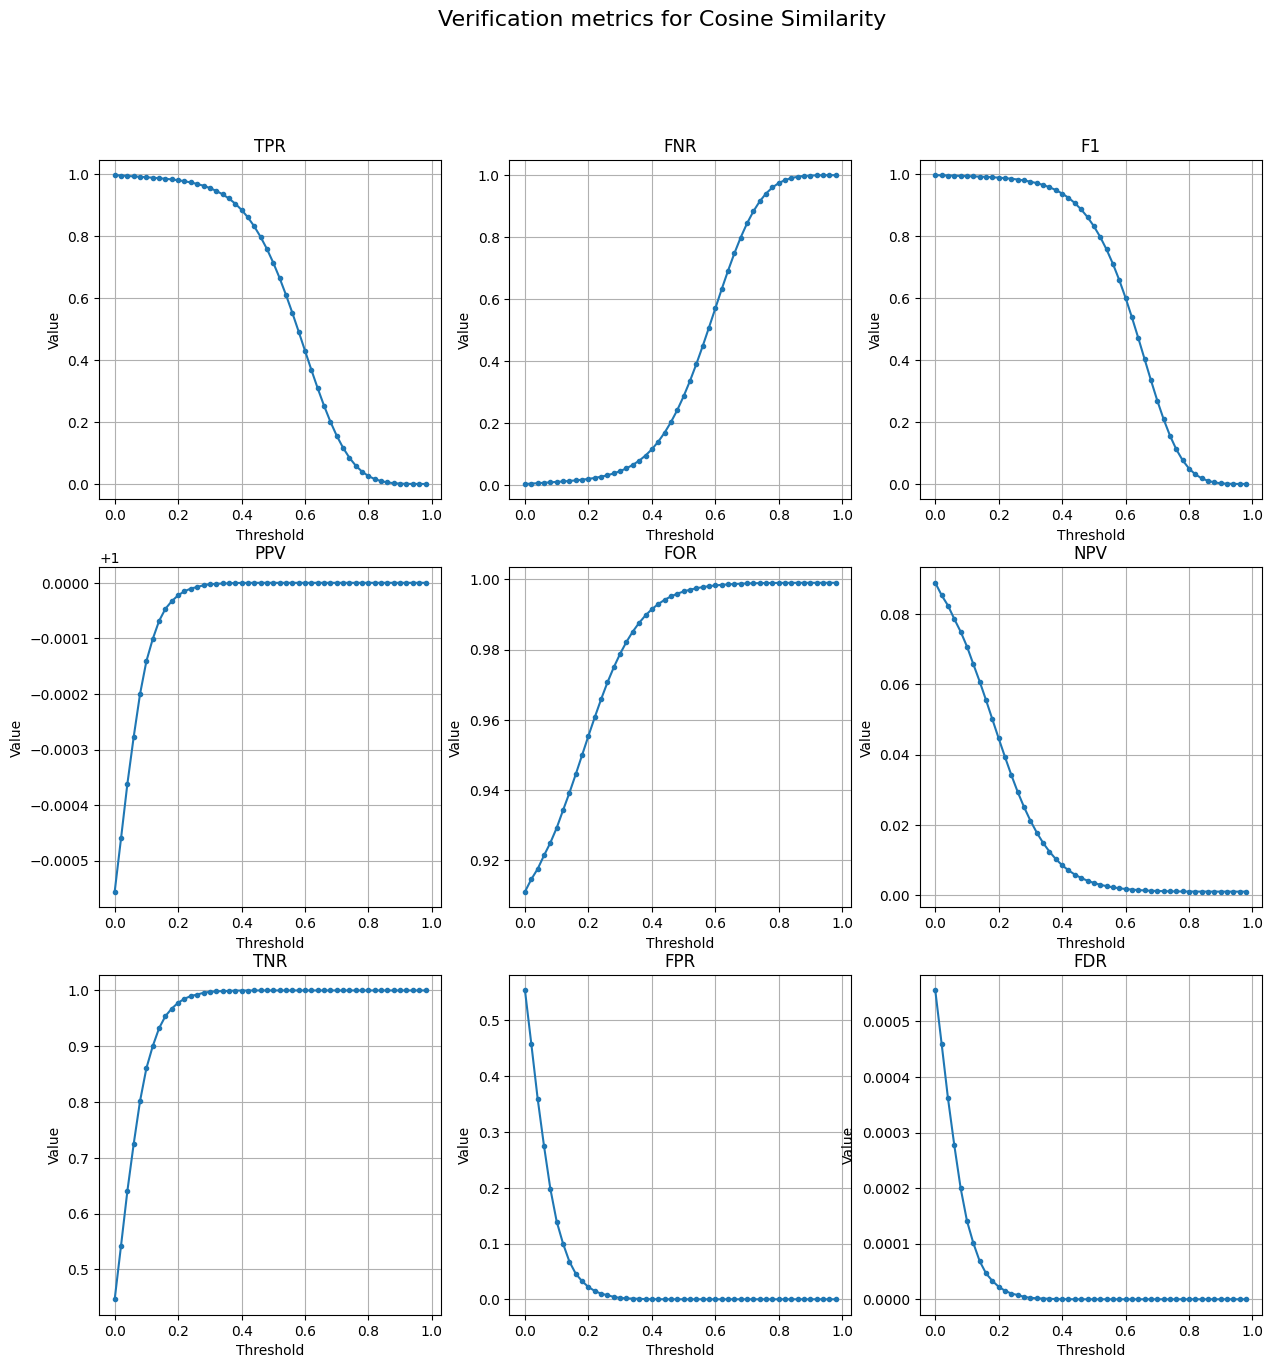

In [17]:
metrics = set()
for details in threshold_results.values():
    metrics.update(details.keys())

rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Adjust size as needed
axes = axes.flatten()  # Flatten the array of axes
fig.suptitle("Verification metrics for Cosine Similarity", fontsize=16)

for i, metric in enumerate(metrics):
    thresholds = sorted(threshold_results.keys())  # Get a sorted list of thresholds
    values = [threshold_results[threshold][metric] for threshold in thresholds]

    ax = axes[i]
    ax.plot(thresholds, values, marker=".")
    ax.set_title(metric)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Value")
    ax.grid(True)